# Mango Leaf Disease Classification
This notebook demonstrates the training of a convolutional neural network (CNN) to classify mango leaf diseases. The dataset is assumed to be located in a directory named `mango`, with subdirectories for each class representing different diseases (or healthy leaves).

In [3]:
import os
import PIL
import shutil
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model


## Dataset Preparation
Using a custom dataset located in the `mango` directory. The dataset must follow the required directory structure, where each class has its own subdirectory.


In [4]:
# Replace this with the path to your mango dataset directory
data_dir = pathlib.Path("./mango")

# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total number of images:", image_count)


Total number of images: 2400


## Loading Data
The data is divided into training and validation sets. 80% of the images are used for training, and 20% are reserved for validation.


In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Use 20% of data for validation
    subset="training",
    seed=123,  # Seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2400 files belonging to 6 classes.
Using 1920 files for training.
Found 2400 files belonging to 6 classes.
Using 480 files for validation.


## Class Names
The classes are automatically inferred from the subdirectory names in the dataset.


In [6]:
class_names = train_ds.class_names
print("Class Names:", class_names)


Class Names: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy']


## Optimizing Dataset Performance
Cache the datasets to memory and shuffle the training dataset to improve performance during training.

In [7]:
train_ds = train_ds.cache().shuffle(1000)
val_ds = val_ds.cache()


## Building the Model
The model is a convolutional neural network with three convolutional layers, max pooling, and dense layers for classification.


In [8]:
num_classes = len(class_names)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training the Model
Train the model for 5 epochs and validate its performance on the validation dataset.


In [9]:
epochs = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("Training Complete!")


Epoch 1/5
60/60 [==============================] - 17s 245ms/step - loss: 1.2718 - accuracy: 0.5016 - val_loss: 0.7675 - val_accuracy: 0.7021
Epoch 2/5
60/60 [==============================] - 14s 234ms/step - loss: 0.5517 - accuracy: 0.8047 - val_loss: 0.4422 - val_accuracy: 0.8396
Epoch 3/5
60/60 [==============================] - 15s 243ms/step - loss: 0.3034 - accuracy: 0.9005 - val_loss: 0.3566 - val_accuracy: 0.8583
Epoch 4/5
60/60 [==============================] - 15s 244ms/step - loss: 0.1979 - accuracy: 0.9380 - val_loss: 0.3954 - val_accuracy: 0.8479
Epoch 5/5
60/60 [==============================] - 18s 302ms/step - loss: 0.1846 - accuracy: 0.9401 - val_loss: 0.3029 - val_accuracy: 0.8917
Training Complete!


## Visualizing Training Results
The training and validation accuracy and loss are plotted to analyze the model's performance.


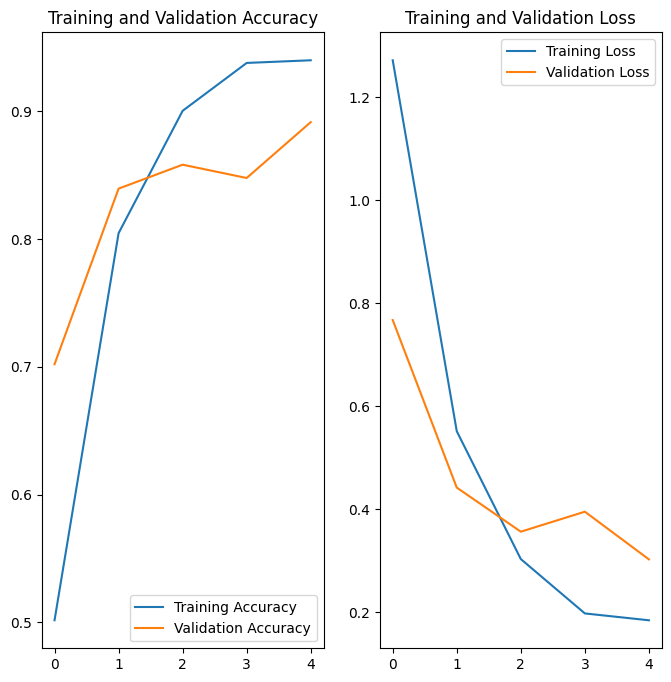

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Saving the Model
Save the trained model to a file for later use.


In [11]:
save_model(model, 'mango_leaf_disease_model.h5')
print("Model Saved")

# Load the saved model from the file
model = tf.keras.models.load_model('mango_leaf_disease_model.h5')
print("Model loaded!")


C:\Users\MSI 15\AppData\Local\Temp\ipykernel_22692\1148261965.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'mango_leaf_disease_model.h5')


Model Saved
Model loaded!


## Evaluate Model on Test Dataset
The metrics below represent the overall performance of the model on the test dataset. This is different from the single-image prediction above, which evaluates the confidence and result for an individual image. Accuracy, precision, recall, and error rate here are averaged across all test samples. 

Current Learning Rate: 0.0010000000474974513
Updated Learning Rate: 9.999999747378752e-05
Found 600 files belonging to 6 classes.
19/19 [==============================] - 2s 72ms/step
**Accuracy:** 88.67%
**Precision:** 0.19
**Recall:** 0.19
**Error Rate:** 11.33%
**Confusion Matrix:**


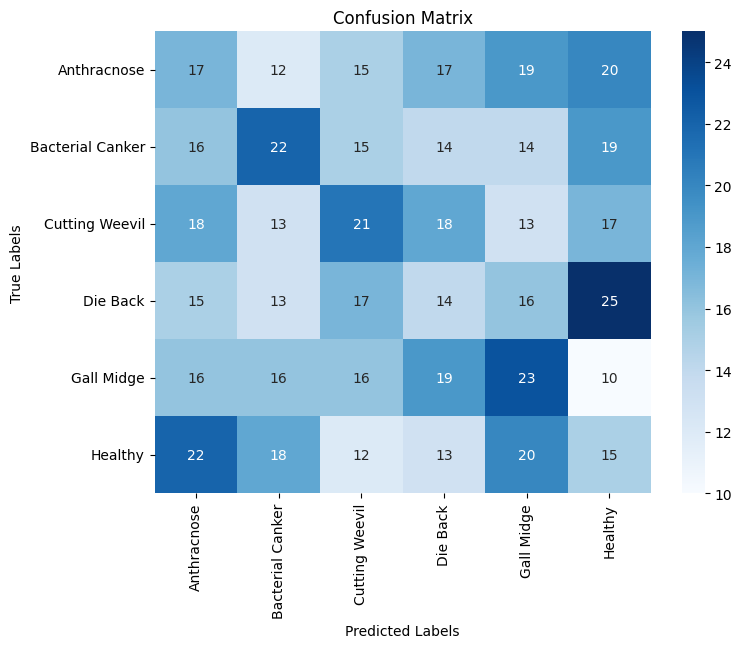

In [12]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming the model is already loaded, and you want to access or set the learning rate

# Display the current learning rate
current_learning_rate = model.optimizer.learning_rate.numpy()  # For TensorFlow 2.x
print(f"Current Learning Rate: {current_learning_rate}")

# Optional: Change the learning rate (e.g., set it to 0.0001)
new_learning_rate = 0.0001
model.optimizer.learning_rate.assign(new_learning_rate)

# Print the updated learning rate
updated_learning_rate = model.optimizer.learning_rate.numpy()
print(f"Updated Learning Rate: {updated_learning_rate}")

# Load test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './test',  # Replace with your test dataset directory
    label_mode='int',
    image_size=(180, 180),
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=-1)

# Metrics
precision = np.mean(y_true == y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
error_rate = (1 - test_accuracy) * 100

# Display metrics
print(f"**Accuracy:** {test_accuracy * 100:.2f}%")
print(f"**Precision:** {precision:.2f}")
print(f"**Recall:** {recall:.2f}")
print(f"**Error Rate:** {error_rate:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("**Confusion Matrix:**")
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


## Testing the Model on New Images
In this section, we will load new mango leaf images, preprocess them, and use the trained model to predict the class with confidence.


In [13]:
from PIL import Image  # Ensure this is imported

def load_and_predict(image_path, model, class_names, img_height=180, img_width=180):
    # Load the image using PIL and convert to a NumPy array
    img = Image.open(image_path)  # Use PIL to open the image
    img = np.array(img)  # Convert to NumPy array
    
    # Resize and cast to float32
    img = tf.image.resize(img, [img_height, img_width])  # Resize to target size
    img = tf.cast(img, tf.float32)  # Cast to float32
    
    # Add batch dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Get predictions
    predictions = model.predict(img)
    probabilities = tf.nn.softmax(predictions[0]).numpy()  # Apply softmax and convert to NumPy
    
    # Get the predicted class and confidence
    predicted_class = class_names[np.argmax(probabilities)]
    confidence = np.max(probabilities) * 100  # Convert to percentage
    
    return predicted_class, confidence


## Testing with a Sample Image
Now, let's test the model with a sample image from the dataset (or a new image). You can specify the path to any leaf image you want to test.


In [22]:
# Replace this with the path to your test image
test_image_path = "./test/Anthracnose/25.jpg"  # Example path

# Call the function to make a prediction
predicted_class, confidence = load_and_predict(test_image_path, model, class_names)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")


1/1 [==============================] - 0s 23ms/step
Predicted Class: Anthracnose
Confidence: 99.09%


## Displaying the Image
Let's visualize the image alongside the predicted class and confidence.

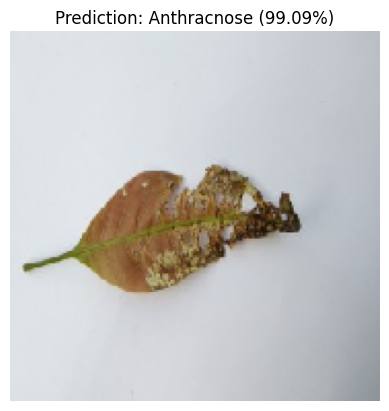

In [23]:
# Display the test image with prediction details
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()
